# WGCNA
Putting WGCNA analyses into a Jupyter notebook for annotation. Bear with me through some of the dataframe manipulations, I find R much less intuitive than Python. We'll turn off warnings for now.

In [1]:
options(warn=-1)

Here are the install lines if you're missing any of the specific tools.

In [5]:
# install.packages(c("matrixStats", "Hmisc", "splines", "foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival"))
# BiocManager::install(c("WGCNA", "GO.db", "preprocessCore", "impute"))

In [2]:
library("WGCNA")
library("statmod")
prolibrary("stringr")
library("dplyr")
library("tidyr")
library("reshape2")
library(ggplot2)
library("ggthemes")
library("ggcorrplot")
library("flashClust")
library("corrr")
theme_set(theme_minimal())
theme_update(axis.line = element_line(color = "black"), axis.ticks = element_line(color="black"))
allowWGCNAThreads()
options(stringsAsFactors = FALSE)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




ERROR: Error in prolibrary("stringr"): could not find function "prolibrary"


I'll be following these two pages from [Wisconsen](http://pages.stat.wisc.edu/~yandell/statgen/ucla/WGCNA/wgcna.html) and [Texas](https://wikis.utexas.edu/display/bioiteam/Clustering+using+WGCNA?preview=/104465671/163879871/WGCNA2017.pdf), as well as the [WGCNA tutorials](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/).

## Data input and cleaning

In [3]:
sleuthData = read.csv("../Network-analysis/P-amilis-gene-norm-filt.WGCNA.csv")
Pamilis_metadata = read.csv("../Abundance-analysis/P-amilis.metadata.csv")
sleuthData$time_point = Pamilis_metadata$time_point
sleuthData$color = Pamilis_metadata$hex_color
sleuthData$treatment = Pamilis_metadata$treatment
names(sleuthData)[names(sleuthData) == "X"] = "sample"

In [4]:
sleuthData[1:10,1:10]

,sample,FUN_000002,FUN_000003,FUN_000004,FUN_000005,FUN_000006,FUN_000007,FUN_000008,FUN_000009,FUN_000010
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P-amilis_002_174_019,0.000000,0,0,0,0,0,0,0,0
2,P-amilis_004_150_043,0.000000,0,0,0,0,0,0,0,0
3,P-amilis_007_114_079,0.000000,0,0,0,0,0,0,0,0
4,P-amilis_009_185_008,1.371509,0,0,0,0,0,0,0,0
5,P-amilis_010_173_020,0.000000,0,0,0,0,0,0,0,0
6,P-amilis_012_149_044,0.000000,0,0,0,0,0,0,0,0
7,P-amilis_019_160_033,0.000000,0,0,0,0,0,0,0,0
8,P-amilis_020_148_045,0.000000,0,0,0,0,0,0,0,0
9,P-amilis_023_112_081,0.000000,0,0,0,0,0,0,0,0


Now I'll split the data into well-watered and drought, and apply a couple filters that remove lowly expressed or low varaince genes, as well as outliers from each dataset.

In [5]:
wwData = sleuthData[sleuthData$treatment=="W",]
dData = sleuthData[sleuthData$treatment=="D",]
dData$time_point = dData$time_point %% 4

In [6]:
wwExp = wwData[, grepl("FUN", names(wwData))]
pass_filter = apply(wwExp, 2, max) >= 5
wwExp = wwExp[,pass_filter]
rownames(wwExp)= sleuthData[sleuthData$treatment=="W","sample"]
dim(wwExp)
wwExp[1:10,1:10]

[1]    24 26760

,FUN_000011,FUN_000029,FUN_000030,FUN_000031,FUN_000032,FUN_000033,FUN_000034,FUN_000035,FUN_000041,FUN_000042
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P-amilis_002_174_019,0.000000,15.245290,4.355797,6.533696,0.000000,19.601087,4.355797,779.6877,339.7522,4.355797
P-amilis_004_150_043,1.719842,5.159527,3.439684,5.159527,11.954170,0.000000,5.159527,620.8630,309.5716,1.719842
P-amilis_007_114_079,1.802860,3.605721,5.408581,3.605721,1.802860,5.408581,5.408581,694.1012,320.9091,0.000000
P-amilis_009_185_008,1.371509,1.371509,2.743017,5.486034,3.447049,5.486034,0.000000,625.4079,311.3324,5.486034
P-amilis_010_173_020,2.624647,5.249293,7.873940,1.312323,1.532860,1.312323,2.624647,898.9415,301.8344,7.873940
P-amilis_012_149_044,0.983197,2.949591,4.915985,5.899182,1.975007,6.882379,5.899182,626.2965,352.9677,1.966394
P-amilis_019_160_033,0.000000,2.816370,1.877580,1.877580,5.632740,7.510320,5.632740,593.3153,396.1694,31.918860
P-amilis_020_148_045,0.000000,1.580672,7.903358,6.322686,0.000000,3.161343,3.161343,520.0409,393.5872,18.968059
P-amilis_023_112_081,5.206732,6.942310,7.810098,6.942310,3.471155,8.677887,6.942310,693.3632,399.1828,17.355774


In [7]:
dExp = dData[, grepl("FUN", names(dData))]
pass_filter = apply(dExp, 2, max) >= 5
dExp = dExp[,pass_filter]
rownames(dExp)= sleuthData[sleuthData$treatment=="D","sample"]
dim(dExp)
dExp[1:10,1:10]

[1]    24 26337

,FUN_000011,FUN_000028,FUN_000029,FUN_000030,FUN_000031,FUN_000032,FUN_000033,FUN_000034,FUN_000035,FUN_000041
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
P-amilis_073_381_196,1.0529406,1.0529406,5.2647028,0.000000,1.0529406,3.841470,2.105881,4.211762,922.3759,620.1820
P-amilis_074_369_208,0.9485144,0.0000000,11.3821729,10.433659,6.6396009,3.005706,13.279202,2.845543,1174.2608,573.8512
P-amilis_075_357_220,1.8826708,0.0000000,0.9413354,3.765342,0.9413354,4.609578,13.178696,2.824006,731.4176,478.1984
P-amilis_076_345_232,2.4646874,0.0000000,4.1078123,9.037187,10.6803120,5.012299,5.750937,5.750937,1035.1687,570.1644
P-amilis_077_333_244,0.0000000,0.9381354,5.6288121,3.752541,4.6906768,7.278152,13.133895,1.876271,1100.4328,604.1592
P-amilis_078_321_256,0.0000000,0.8739107,7.8651960,3.495643,1.7478213,8.575510,10.486928,2.621732,1221.7271,640.5765
P-amilis_079_309_268,1.6416222,0.0000000,8.2081109,11.491355,5.7456776,8.477175,16.416222,4.104055,1456.9397,573.7469
P-amilis_080_297_280,0.0000000,0.0000000,5.5931072,6.525292,5.5931072,6.054057,7.457476,0.000000,1851.3185,703.7993
P-amilis_081_380_197,4.1353811,0.0000000,4.1353811,9.304607,5.1692263,7.249357,17.575369,4.135381,1835.0753,864.2946


In [8]:
length(intersect(colnames(wwExp), colnames(dExp)))/length(union(colnames(wwExp), colnames(dExp)))

[1] 0.8830059

So we've roughly halved both datasets: well-watered contains 26,760 genes, which the drought set contains 26,337. These two datasets largely overlap (~88%), but that does mean that thousands of genes differ between the two. The function `goodSamplesGenes` will flag genes with too low variance or that are outliers.

In [9]:
ww_gsg = goodSamplesGenes(datExpr = wwExp, verbose = 3)
ww_gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

So no genes were removed from the well-watered dataset, now on to the drought samples.

In [10]:
d_gsg = goodSamplesGenes(datExpr = dExp, verbose = 3)
d_gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

No genes were removed here either, so we're on to the final filtering step: removing entire samples that are outliers. We'll do this by hierarchically clustering our samples and cuttinng branches from the resulting tree.

In [11]:
wwSampleTree = hclust(dist(wwExp), method = "average")
dSampleTree = hclust(dist(dExp), method = "average")

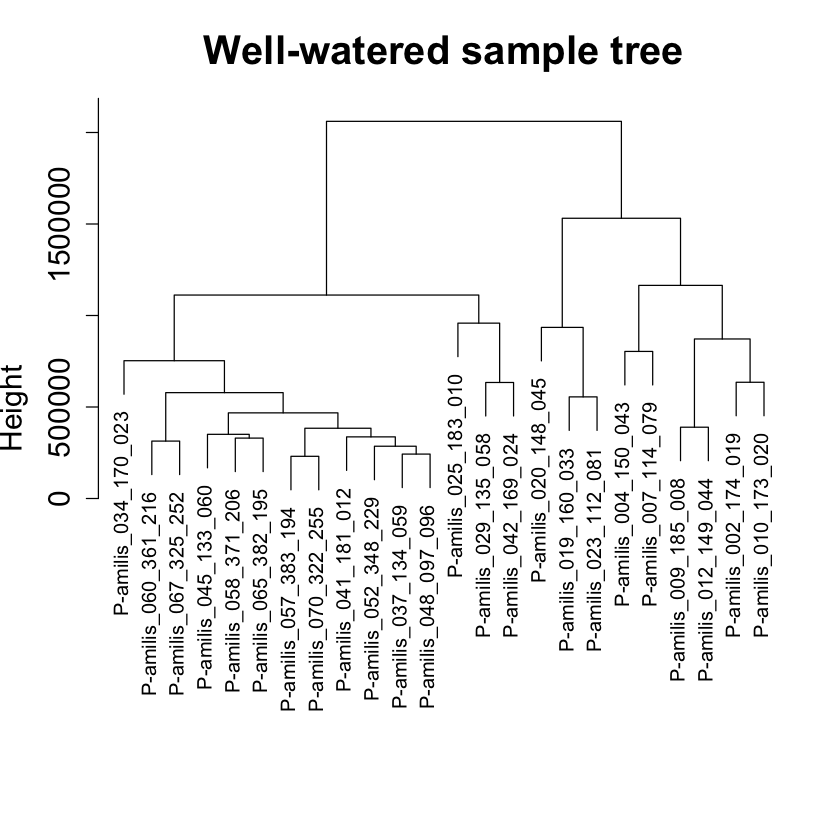

In [12]:
plot(wwSampleTree, main = "Well-watered sample tree", sub="", xlab="", cex.lab=1.5, cex.axis=1.5, cex.main=2)

So no obvious outliers in the well-watered data.

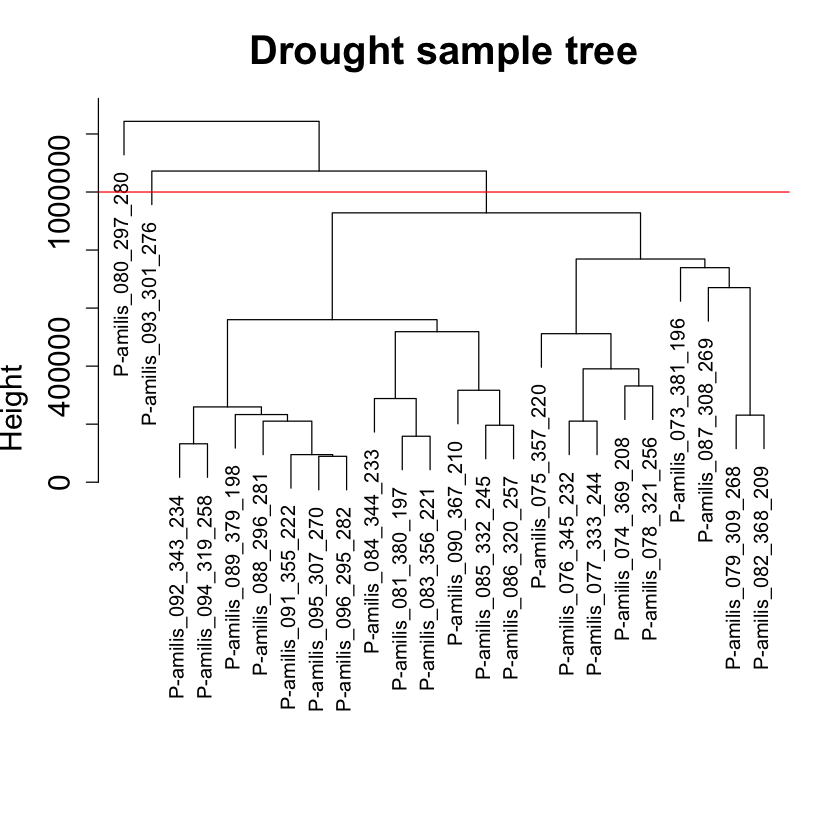

In [13]:
plot(dSampleTree, main = "Drought sample tree", sub="", xlab="", cex.lab=1.5, cex.axis=1.5, cex.main=2)
abline(h = 1000000, col="red")

However, it looks like we do have two samples in the drought data that should be pruned.

In [14]:
dCuttree = cutreeStatic(dSampleTree, cutHeight = 1000000, minSize = 10) 
dKeepSamples = (dCuttree==1)
dExp = dExp[dKeepSamples, ]

In [15]:
wwNGenes = ncol(wwExp)
wwNSamples = nrow(wwExp)
dNGenes = ncol(dExp)
dNSamples = nrow(dExp)
dim(wwExp)
dim(dExp)

[1]    24 26760

[1]    22 26337

In [16]:
rownames(wwData) = wwData$sample
rownames(dData) = dData$sample

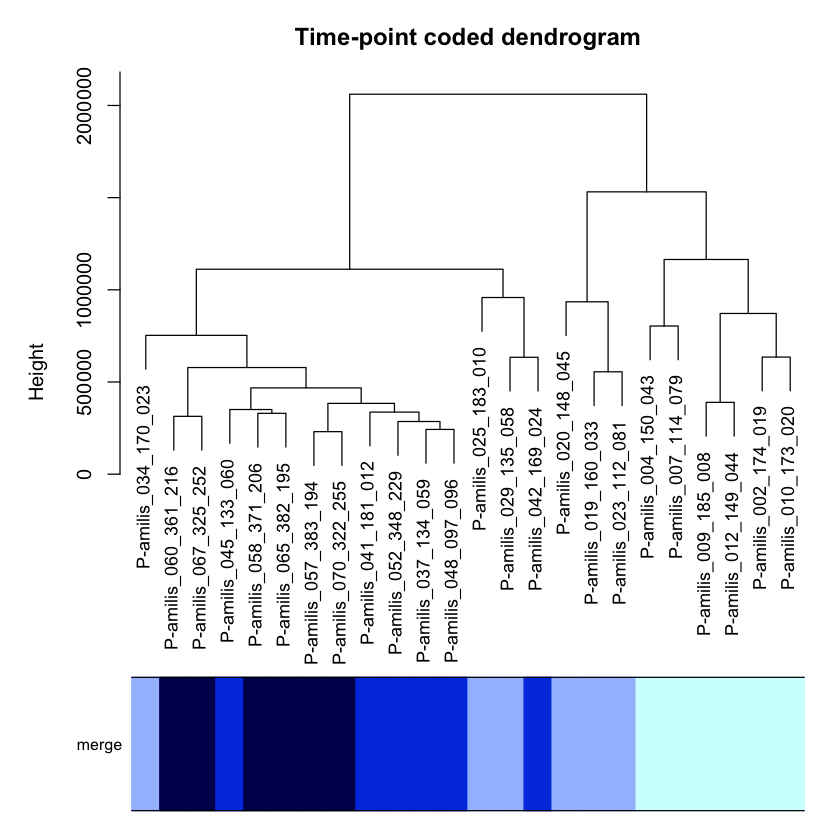

In [17]:
wwMetaTree = hclust(dist(wwExp), method = "average")
plotDendroAndColors(dendro = wwMetaTree, colors = wwData$color, groupLabels = names(wwMetaTree),
                    main = "Time-point coded dendrogram")

In the figure above, the colors represent time points from earliest (lightest blue) to latest (darkest blue). Besides the morning samples, each time point does not form it's own cluster.

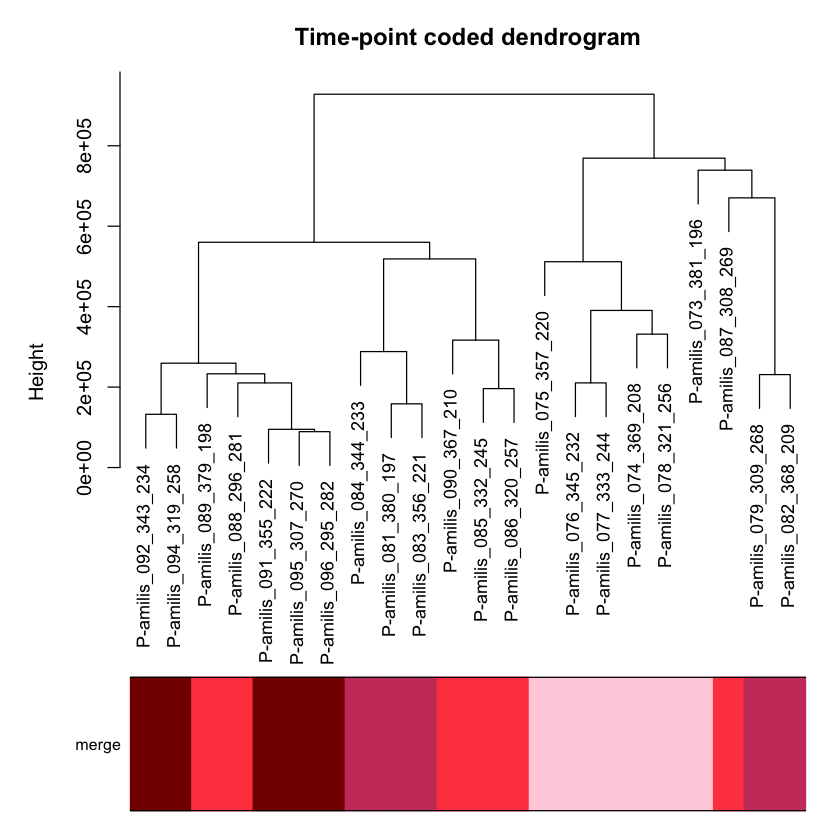

In [18]:
dMetaTree = hclust(dist(dExp), method = "average")
plotDendroAndColors(dendro = dMetaTree, colors = dData[rownames(dExp),"color"], groupLabels = names(dMetaTree),
                    main = "Time-point coded dendrogram")

The pattern for the drought data is similar. I'll save some of the more important data structures so they can be easily loaded in the future.

In [19]:
# save(wwExp, dExp, file = "../Network-analysis/WCGNA/wwExpr-dExpr.genes.RData")

In [20]:
load("../Network-analysis/WGCNA/wwExpr-dExpr.genes.RData")

## Network connstruction and module detection
In order to use the `blockwiseModules` function that automatically creates the network and detect modules, we first need to determine the soft threshold powers that render our networks [scale free](https://en.wikipedia.org/wiki/Scale-free_network).

In [21]:
powers = c(c(1:10), seq(from = 12, to = 16, by = 2))
wwSft = pickSoftThreshold(data = wwExp, powerVector = powers, verbose = 5, blockSize = 5000)
dSft = pickSoftThreshold(data = dExp, powerVector = powers, verbose = 5, blockSize = 5000)

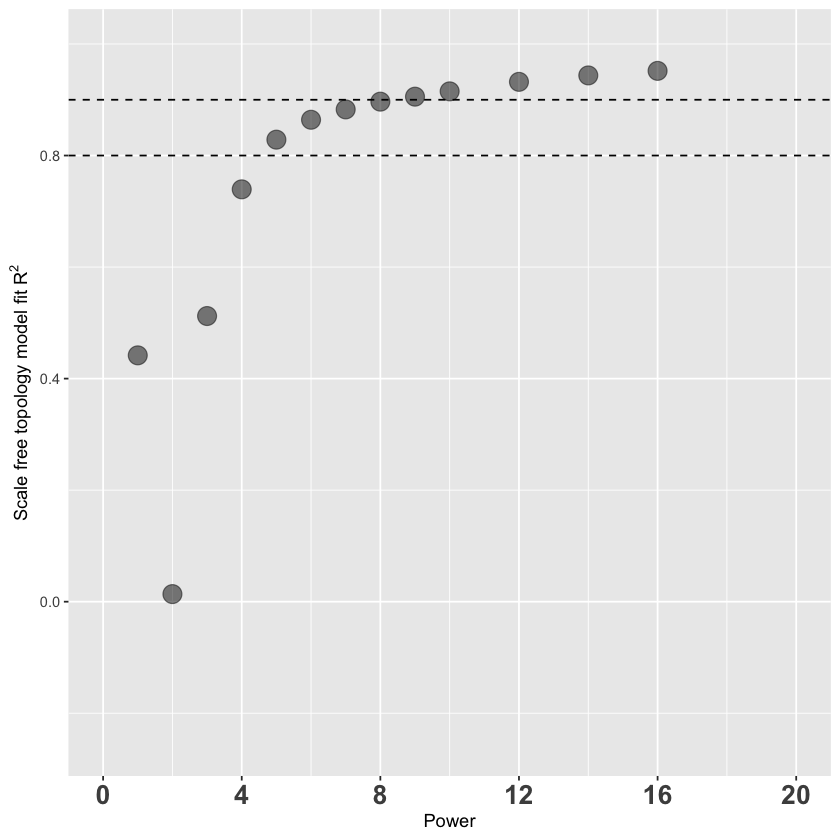

In [138]:
ggplot(data = wwSft$fitIndices, aes(x=Power, y = abs(-sign(slope)*SFT.R.sq))) + 
    geom_point(alpha=0.5, size=5) + 
    geom_hline(yintercept = 0.80, linetype="dashed") + 
    geom_hline(yintercept = 0.90, linetype="dashed") + 
    scale_x_continuous(name="Power", breaks=seq(from=0, to=20, by=4), limits=c(0, 20)) +
    scale_y_continuous(name=expression(paste("Scale free topology model fit R"^2)), limits=c(-0.25,1)) +
    theme(axis.text.x = element_text(face = "bold", size = 16))

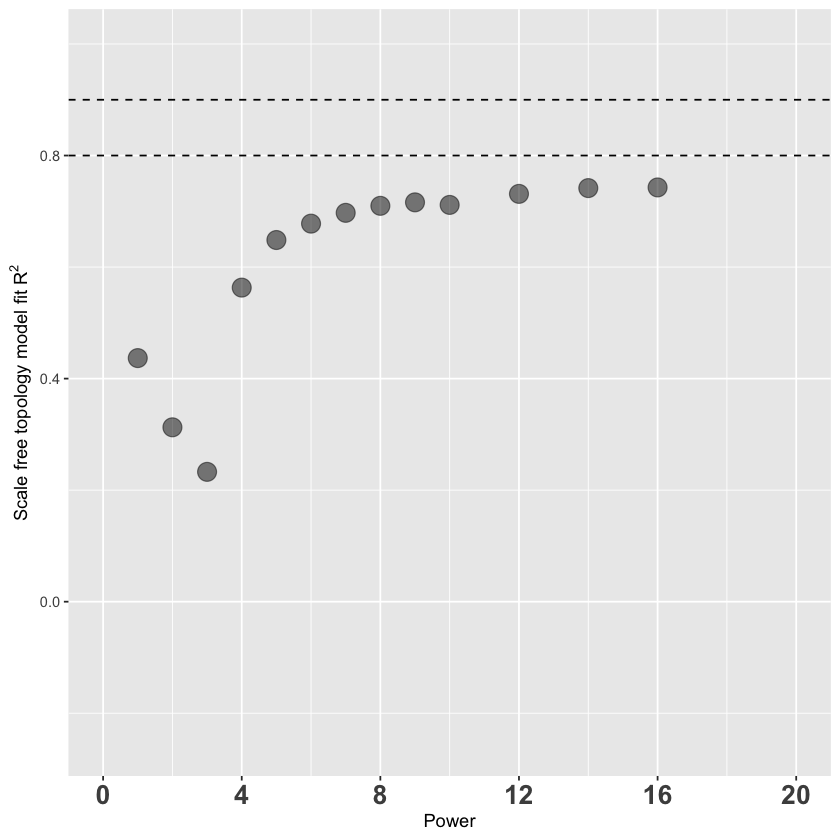

In [139]:
ggplot(data = dSft$fitIndices, aes(x=Power, y = abs(-sign(slope)*SFT.R.sq))) + 
    geom_point(alpha=0.5, size=5) + 
    geom_hline(yintercept = 0.80, linetype="dashed") + 
    geom_hline(yintercept = 0.90, linetype="dashed") + 
    scale_x_continuous(name="Power", breaks=seq(from=0, to=20, by=4), limits=c(0, 20)) +
    scale_y_continuous(name=expression(paste("Scale free topology model fit R"^2)), limits=c(-0.25,1)) +
    theme(axis.text.x = element_text(face = "bold", size = 16))

So the well-watered data reach an $R^2$ = 0.9 around 8, but the drought data never do and rather approach what looks like an asymptote around $R^2$ = 0.75.

In [142]:
dSft$fitIndices

Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.4367956,4.3466554,0.2899926,8327.84681,8554.18200,12326.1303
2,0.3126841,0.7352483,0.8819234,3897.81546,3915.16524,7579.4581
3,0.2327884,-0.3563316,0.8184847,2195.57814,2098.91990,5274.9340
4,0.5631471,-0.7043260,0.8419956,1381.18579,1230.76653,3939.6546
5,0.6485134,-0.8996529,0.8483827,935.15391,769.79572,3078.2713
6,0.6778732,-1.0227623,0.8561527,667.21340,507.80202,2482.0755
7,0.6972232,-1.1123312,0.8698430,495.06994,348.76680,2048.1530
8,0.7097968,-1.1756034,0.8826053,378.68906,247.12035,1722.6146
9,0.7160592,-1.2339274,0.8912182,296.80023,178.56624,1471.0801


For the drought data I'll go with a power of 8 as well because further gains in explainatory power comes with reduced connectivity.

In [3]:
wwSft = 8
dSft = 8

Finally, we can do network construction and module detection.

In [145]:
wwNet = blockwiseModules(wwExp, checkMissingData = TRUE, maxBlockSize = 5000, power=wwSft, networkType = "signed", 
                         corType = "bicor", TOMType = "signed", deepSplit = 2, maxPOutliers = 0.05,
                         mergeCutHeight = 0.25, saveTOMs = FALSE, numericLabels = TRUE, minModuleSize = 30)

Warning message in bicor(structure(c(6.53369578000792, 0, 3.60572054088728, 2.74301701042305, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(0, 11.954169537377, 1.80286027044364, 3.44704903392484, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(263.525729793653, 244.217598033942, 200.117490019244, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(65.3369578000792, 65.3540051076745, 70.3115505473019, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(76.5429546756556, 102.324461428299, 87.3454116142244, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for ind

In [146]:
dNet = blockwiseModules(dExp, checkMissingData = TRUE, maxBlockSize = 5000, power=dSft, networkType = "signed", 
                        corType = "bicor", TOMType = "signed", deepSplit = 2, maxPOutliers = 0.05,
                        mergeCutHeight = 0.25, saveTOMs = FALSE, numericLabels = TRUE, minModuleSize = 30)

Warning message in bicor(structure(c(55.4677011113662, 76.3434100082919, 45.6535560182927, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(575.958487465735, 573.851219333026, 536.561175315508, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(4.21176224837832, 2.84554323636211, 2.8240061858711, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(827.611281806339, 1003.5282480237, 822.727135483779, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in bicor(structure(c(27.3764546144591, 21.8158314787762, 10.354689348194, :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual 

We can access the module assignments through the color labels.

In [147]:
wwMergedColors = labels2colors(wwNet$colors)
dMergedColors = labels2colors(dNet$colors)

In [170]:
length(table(wwMergedColors))

[1] 41

In [169]:
length(table(dMergedColors))

[1] 21

So the drought network contains fewer, but larger, modules compared to the well-watered network. Now I'll do a quick plot of the dendrogram of the network correlated with time.

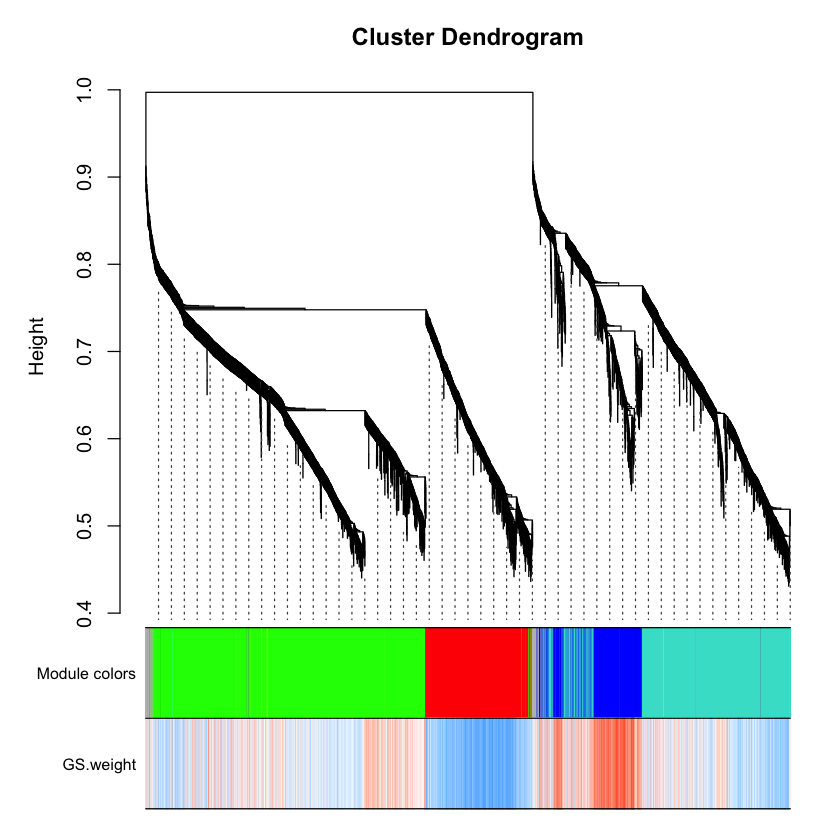

In [157]:
# Correlate with time
wwTime = as.data.frame(wwData$time_point)
names(wwTime) = "time"
# Next use time point to define a gene significance variable
wwGS.time = as.numeric(cor(wwExp, wwTime, use = "p"))
# This translates the numeric values into colors
wwGS.timeColor = numbers2colors(wwGS.time, signed = T)
blocknumber = 1
wwDatColors = data.frame(wwMergedColors, wwGS.timeColor)[wwNet$blockGenes[[blocknumber]],] 
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(wwNet$dendrograms[[blocknumber]], 
                    colors = wwDatColors, 
                    groupLabels = c("Module colors", "GS.weight"), 
                    dendroLabels = FALSE, 
                    hang = 0.03, 
                    addGuide = TRUE, 
                    guideHang = 0.05)

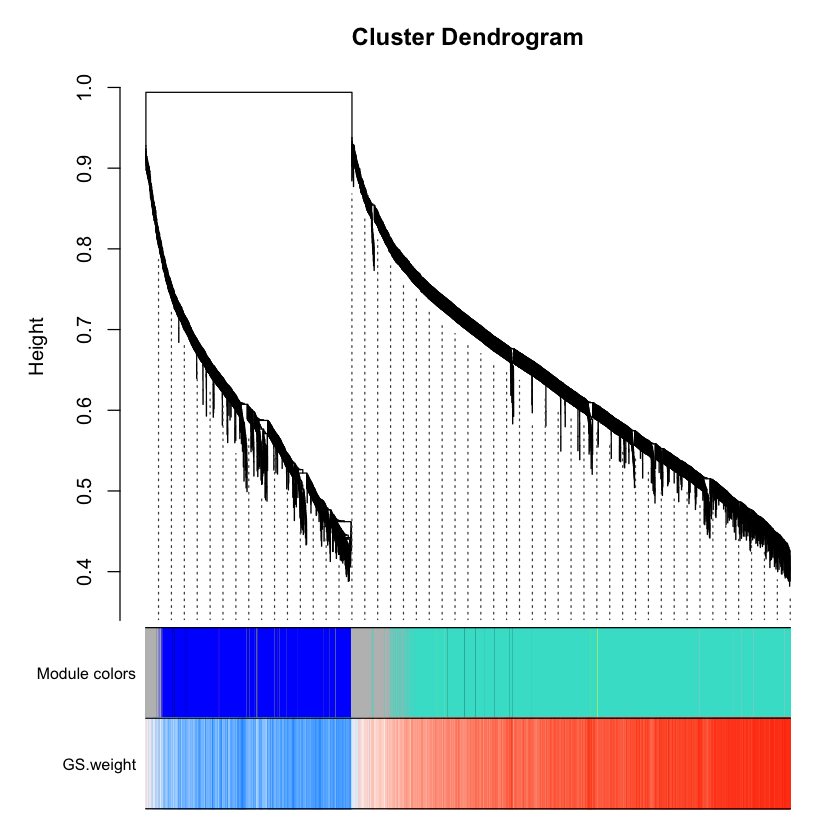

In [164]:
# Correlate with time
dTime = as.data.frame(dData[rownames(dExp),]$time_point)
names(dTime) = "time"
# Next use time point to define a gene significance variable
dGS.time = as.numeric(cor(dExp, dTime, use = "p"))
# This translates the numeric values into colors
dGS.timeColor = numbers2colors(dGS.time, signed = T)
blocknumber = 1
dDatColors = data.frame(dMergedColors, dGS.timeColor)[dNet$blockGenes[[blocknumber]],] 
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(dNet$dendrograms[[blocknumber]], 
                    colors = dDatColors, 
                    groupLabels = c("Module colors", "GS.weight"), 
                    dendroLabels = FALSE, 
                    hang = 0.03, 
                    addGuide = TRUE, 
                    guideHang = 0.05)

Again, I'll save the more time consuming data structure, as well as the module assignments for use elsewhere.

In [165]:
# save(wwNet, dNet, file = "../Network-analysis/WGCNA/wwNet-dNet.genes.RData")
# write.csv(wwNet$colors, "../Network-analysis/WGCNA/Well-watered-module-labels.genes.csv")
# write.csv(dNet$colors, "../Network-analysis/WGCNA/Drought-module-labels.genes.csv")

In [3]:
load("../Network-analysis/WGCNA/wwNet-dNet.genes.RData")

## Subsetting adjacency matrices
The adjacency matrix is the underlying structure of a network, and it's what we'll need for visualization and analysis of a network. These matrices in our case are very large (a few Gb), and contain tons of information we aren't immediately interested in. For the purposes of this work on _Portulaca_ co-expression networks, we're really concerned with the photosynthesis-related genes. I'll extract the over 500 photosynthesis-related genes from the two adjacency matrices for analysis in NetworkX (Python).

In [24]:
pathway_assgns = read.csv('../Submission-files/MBE/Gilman-etal-Supplementary-Data-S1.csv')
head(pathway_assgns)

,Orthogroup,Arabidopsis.ortholog,genemodel,Label,Gene.family,Block.description,Pathway,Localization,qval,WGCNA_ww,WGCNA_d
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,OG0002519,"AT5G50370, AT5G63400",FUN_011473,ADK3-2,ADK,Adenylate kinase 3,PEP generation,chloroplast,0.0261046347,2,13
2,OG0006840,AT5G35170,FUN_026031,ADK5-1,ADK,Adenylate kinase 5,PEP generation,chloroplast,0.0001809558,3,2
3,OG0002519,"AT5G50370, AT5G63400",FUN_046898,ADK3-1,ADK,Adenylate kinase 3,PEP generation,chloroplast,0.1540561055,1,6
4,OG0011322,AT5G47840,FUN_048323,ADK2-1,ADK,Adenylate kinase 2,PEP generation,chloroplast,0.1522087778,3,5
5,OG0005172,"AT2G18915,AT5G57360",FUN_013066,ADO1-1,ADO/ZTL,Adagio/Zeitlupe 1,Circadian/Light response,,0.0490642214,5,4
6,OG0012906,AT1G68050,FUN_023069,ADO3-1,ADO/ZTL,Adagio/Zeitlupe 3,Circadian/Light response,,0.2738222166,5,4


In [25]:
dim(pathway_assgns)

[1] 516  11

In [6]:
wwSft = 8
dSft = 8

In [7]:
ww_genemodel_idx = match(pathway_assgns$genemodel, colnames(wwExp))
ww_genemodel_idx = ww_genemodel_idx[!is.na(ww_genemodel_idx)]
ww_subadj = adjacency(wwExp, selectCols = ww_genemodel_idx, type = "signed", power = wwSft, )
ww_kept = colnames(ww_subadj)
ww_adj_genemodel_idx = match(ww_kept, rownames(ww_subadj))
ww_adj_genemodel_idx = ww_adj_genemodel_idx[!is.na(ww_adj_genemodel_idx)]
ww_subadj = adjacency(wwExp, selectCols = ww_adj_genemodel_idx, type = "signed", power = wwSft)
ww_kept = colnames(ww_subadj)
ww_subadj = ww_subadj[ww_kept,]
# write.csv(ww_subadj, "../Network-analysis/Well-watered-subadj.csv")

In [8]:
d_genemodel_idx = match(pathway_assgns$genemodel, colnames(dExp))
d_genemodel_idx = d_genemodel_idx[!is.na(d_genemodel_idx)]
d_subadj = adjacency(dExp, selectCols = d_genemodel_idx, type = "signed", power = dSft, )
d_kept = colnames(d_subadj)
d_adj_genemodel_idx = match(d_kept, rownames(d_subadj))
d_adj_genemodel_idx = d_adj_genemodel_idx[!is.na(d_adj_genemodel_idx)]
d_subadj = adjacency(dExp, selectCols = d_adj_genemodel_idx, type = "signed", power = dSft)
d_kept = colnames(d_subadj)
d_subadj = d_subadj[d_kept,]
write.csv(d_subadj, "../Network-analysis/Drought-subadj.csv")